<a href="https://colab.research.google.com/github/DiwakarBasnet/GIF_recommender/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
BATCH_SIZE = 64      # Number of training samples to work through before model's internal parameters are upadted
IMAGE_SIZE = 128     # Size of image
CHANNELS = 3         # RGB channels
EPOCHS = 20          # Number of passes of the entire training dataset

In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load dataset from kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
# allocate required permission for file
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d msambare/fer2013

 86% 52.0M/60.3M [00:00<00:00, 192MB/s]
100% 60.3M/60.3M [00:00<00:00, 186MB/s]


In [ ]:
! unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

# Train test split

In [ ]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./train",
    seed = 123,
    shuffle = True,
    labels = "inferred",
    label_mode = "int",
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 28709 files belonging to 7 classes.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./test",
    seed = 123,
    shuffle = True,
    labels = "inferred",
    label_mode = "int",
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 7178 files belonging to 7 classes.


In [ ]:
ds_size = len(ds)
train_size = int(0.75 * ds_size)
val_size = int(0.25 * ds_size)

In [ ]:
train_ds = ds.take(train_size)
val_ds = ds.skip(train_size).take(val_size)

# Data Visualization

In [ ]:
class_names = ds.class_names
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

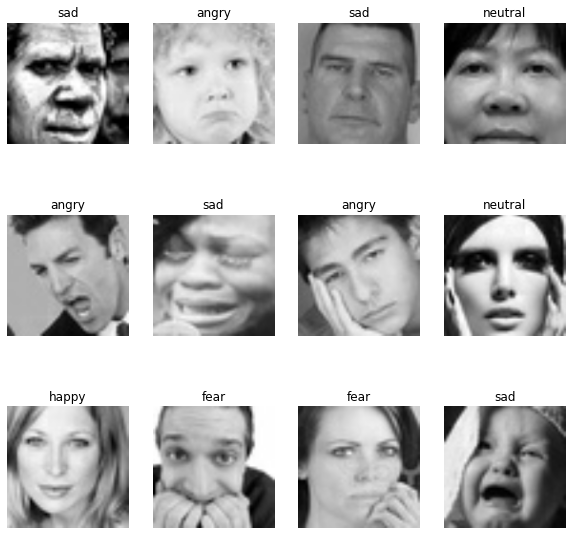

In [ ]:
plt.figure(figsize = (10, 10))
for image_batch, label_batch in ds.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

# Preprocessing

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
          tf.keras.layers.experimental.preprocessing.Rescaling(1.0/47)
])

In [ ]:
# data_augmentation = tf.keras.Sequential([
#           tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#           tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
# ])

# Build and train model

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
            resize_and_rescale,
            #data_augmentation,

            # 1st convolution layer
            layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
            layers.MaxPool2D((2,2)),
            layers.Dropout(0.5),

            # 2nd convolution layer
            layers.Conv2D(64, (3,3), activation='relu'),
            layers.MaxPool2D((2,2)),
            layers.Dropout(0.5),

            # 3rd convolution layer
            layers.Conv2D(128, (3,3), activation='relu'),
            layers.MaxPool2D((2,2)),

            layers.Flatten(),

            layers.Dense(1024, activation='relu'),
            layers.Dropout(0.2),
            
            layers.Dense(7, activation='softmax')
])

model.build(input_shape = input_shape)        # model.build is required by api

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 126, 126, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (64, 63, 63, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (64, 63, 63, 64)          0         
                                                                 
 conv2d_1 (Conv2D)           (64, 61, 61, 64)          36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 30, 30, 64)         0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds,
    shuffle = True
)

# Saving the  model to  use it later on
fer_json = model.to_json()
with open("drive/MyDrive/Models/model.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("drive/MyDrive/Models/model.h5")

Epoch 1/20
336/336 [==============================] - 55s 100ms/step - loss: 2.7505 - accuracy: 0.2516 - val_loss: 1.8181 - val_accuracy: 0.2573
Epoch 2/20
336/336 [==============================] - 22s 66ms/step - loss: 1.7240 - accuracy: 0.3104 - val_loss: 1.7728 - val_accuracy: 0.3059
Epoch 3/20
336/336 [==============================] - 22s 65ms/step - loss: 1.6257 - accuracy: 0.3621 - val_loss: 1.6920 - val_accuracy: 0.3266
Epoch 4/20
336/336 [==============================] - 22s 65ms/step - loss: 1.5542 - accuracy: 0.3932 - val_loss: 1.5837 - val_accuracy: 0.3936
Epoch 5/20
336/336 [==============================] - 22s 66ms/step - loss: 1.4789 - accuracy: 0.4244 - val_loss: 1.5421 - val_accuracy: 0.4139
Epoch 6/20
336/336 [==============================] - 22s 65ms/step - loss: 1.3987 - accuracy: 0.4618 - val_loss: 1.4473 - val_accuracy: 0.4481
Epoch 7/20
336/336 [==============================] - 22s 65ms/step - loss: 1.3192 - accuracy: 0.4988 - val_loss: 1.4235 - val_accuracy

In [ ]:
scores = model.evaluate(test_ds)

113/113 [==============================] - 7s 23ms/step - loss: 2.4906 - accuracy: 0.4746


# Plot training history on graph

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

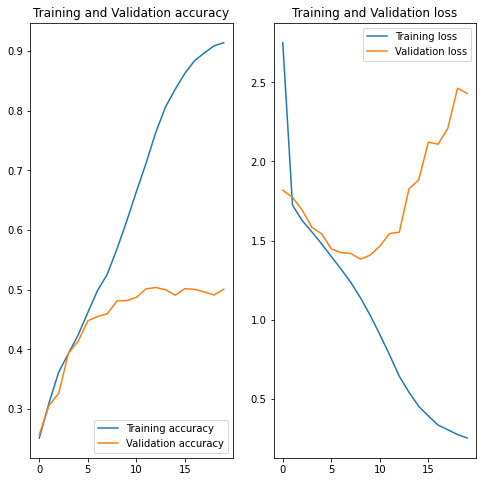

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

plt.show()

# Predictions on Sample images

In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)

  return predicted_class, confidence

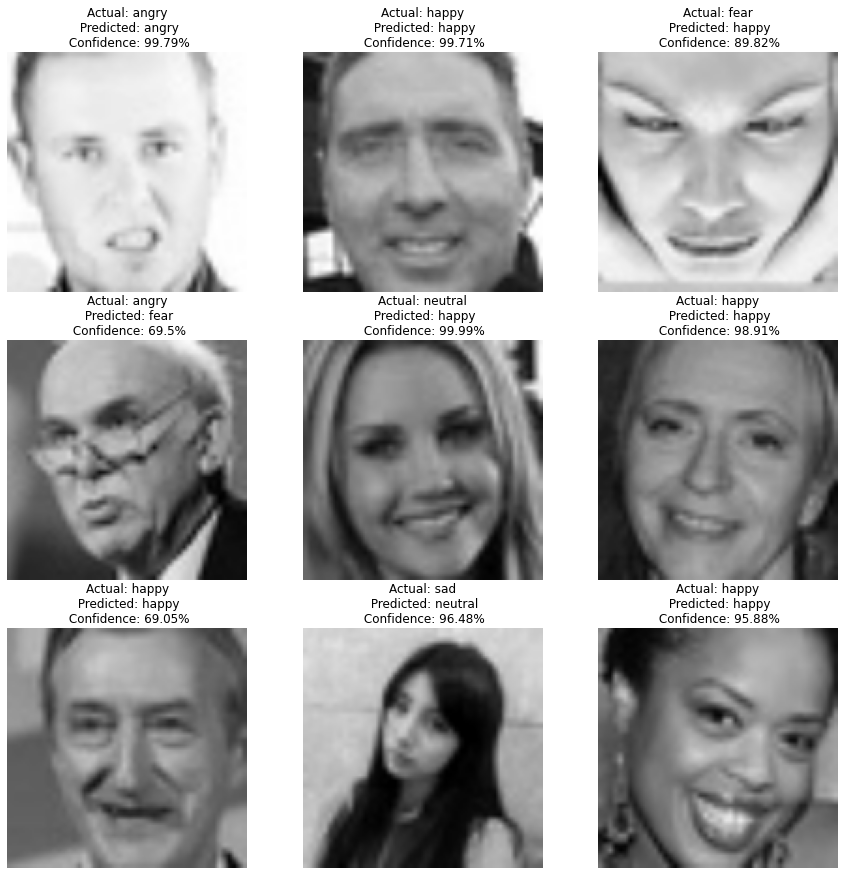

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}\n Confidence: {confidence}%")
    plt.axis("off")

In [ ]:
model_name = "emotion_recognizer"
model.save(f"./drive/MyDrive/Models/{model_name}")

INFO:tensorflow:Assets written to: ./drive/MyDrive/Models/emotion_recognizer/assets
